In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#UDF
from lib.functions import split_OHE, eval_metrics, pos_neg_return, column_datetime_timedelta

#clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [2]:
#importing dataframes
NYSE_Weather = pd.read_csv('../data/NYSE_Weather.csv')
NYC_no_outliers = pd.read_csv('../data/NYC_no_outliers.csv')
Monthly_NYC = pd.read_csv('../data/Monthly_averages.csv')

In [3]:
NYSE_Weather.head()

,Date,Open,Close,Volume,Returns,Hours_of_Sunlight,HOS_Numeric,temp,humidity,precip,preciptype,snow,windspeed,cloudcover,visibility,sunrise,sunset,conditions,description
0,1985-01-03,1005.030029,1005.030029,0.0,-0.398390,0 days 09:20:42,9.345000,0.3,54.6,0.000,none,0.0,26.2,100.0,25.2,07:20:26,16:41:08,Overcast,Cloudy skies throughout the day.
1,1985-01-04,1000.270020,1000.270020,0.0,-0.473619,0 days 09:21:36,9.360000,-1.1,58.1,1.247,"rain,snow",0.0,23.0,99.1,18.9,07:20:26,16:42:02,"Snow, Rain, Overcast",Cloudy skies throughout the day with late afte...
2,1985-01-07,1003.340027,1003.340027,0.0,0.306918,0 days 09:24:39,9.410833,2.9,78.3,0.000,none,0.0,22.1,99.3,13.3,07:20:15,16:44:54,Overcast,Cloudy skies throughout the day.
3,1985-01-08,1002.500000,1002.500000,0.0,-0.083723,0 days 09:25:46,9.429444,-1.5,57.0,0.000,none,0.0,46.8,32.1,29.5,07:20:07,16:45:53,Partially cloudy,Partly cloudy throughout the day.
4,1985-01-09,1009.159973,1009.159973,0.0,0.664336,0 days 09:26:59,9.449722,-7.9,51.4,0.000,none,0.0,40.8,0.9,34.5,07:19:56,16:46:55,Clear,Clear conditions throughout the day.


### Linear Regression (Monthly Returns vs Sunlight Hours)
- Investigating relationship found in EDA notebook

In [5]:
Monthly_NYC.head()

,Date,Avg_Returns,Avg_Returns_N/O,Hours_of_Sunlight(Time),Hours_of_Sunlight(Numeric)
0,1,0.042002,0.087407,0 days 09:39:17.951371571,9.654986
1,2,0.019312,0.089709,0 days 10:39:37.815261044,10.660504
2,3,0.042535,0.076085,0 days 11:57:43.722482435,11.962145
3,4,0.081893,0.068025,0 days 13:19:36.336645962,13.326760
4,5,0.043694,0.039235,0 days 14:26:51.105454545,14.447529


In [6]:
#defining variables for linear regression
y = Monthly_NYC['Avg_Returns_N/O']
x= Monthly_NYC['Hours_of_Sunlight(Numeric)']

x = sm.add_constant(x) #adds a constant/intercept for the regression

#create and fit regression
model = sm.OLS(y, x)
regression = model.fit()

In [7]:
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:        Avg_Returns_N/O   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     6.463
Date:                Tue, 05 Dec 2023   Prob (F-statistic):             0.0293
Time:                        02:14:19   Log-Likelihood:                 28.333
No. Observations:                  12   AIC:                            -52.67
Df Residuals:                      10   BIC:                            -51.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\l3onw\anaconda3\envs\LHL_env\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


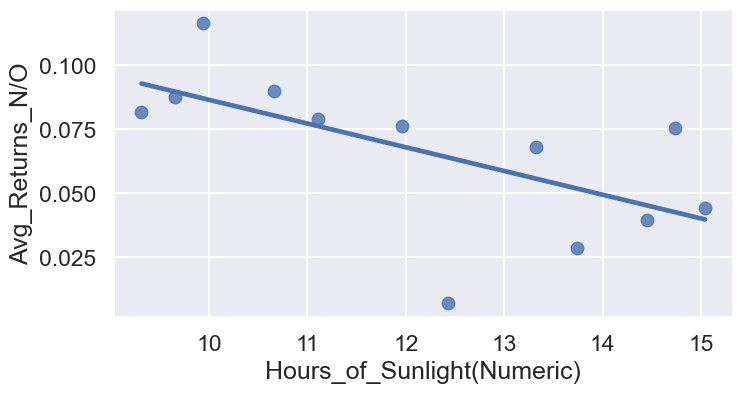

In [8]:
#setting theme and plotting regression
sns.set_theme(style = 'darkgrid', context = 'talk')

plt.figure(figsize=(8,4))
sns.regplot(x=Monthly_NYC['Hours_of_Sunlight(Numeric)'], y = Monthly_NYC['Avg_Returns_N/O'], ci=None)

#saving image
plt.savefig('../images/Linear_Regression.png')

- Negative relationship between average monthly returns and hours of sunlight 
- SAD investors require higher returns to justify holding risky securities
- “Happier” investors are much more optimistic
    - Willing to accept lower/negative returns in hopes of portfolio appreciation


<Axes: ylabel='Count'>

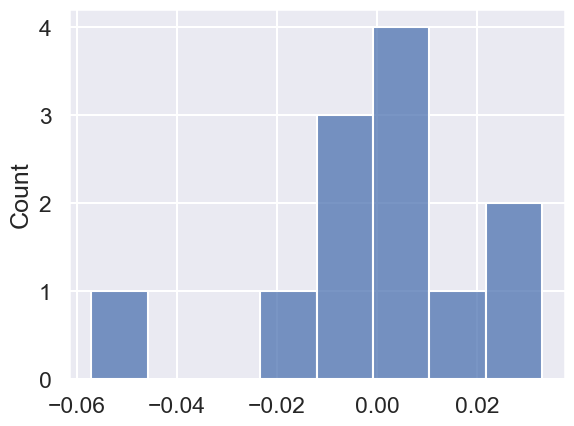

In [9]:
#check distribution of residuals
residuals = regression.resid

sns.histplot(residuals, bins = 8)

### Kmeans Clustering

Cluster different days based on weather conditions to distinguish which types of days have what type of impact on market returns

In [10]:
NYSE_Weather.head()

,Date,Open,Close,Volume,Returns,Hours_of_Sunlight,HOS_Numeric,temp,humidity,precip,preciptype,snow,windspeed,cloudcover,visibility,sunrise,sunset,conditions,description
0,1985-01-03,1005.030029,1005.030029,0.0,-0.398390,0 days 09:20:42,9.345000,0.3,54.6,0.000,none,0.0,26.2,100.0,25.2,07:20:26,16:41:08,Overcast,Cloudy skies throughout the day.
1,1985-01-04,1000.270020,1000.270020,0.0,-0.473619,0 days 09:21:36,9.360000,-1.1,58.1,1.247,"rain,snow",0.0,23.0,99.1,18.9,07:20:26,16:42:02,"Snow, Rain, Overcast",Cloudy skies throughout the day with late afte...
2,1985-01-07,1003.340027,1003.340027,0.0,0.306918,0 days 09:24:39,9.410833,2.9,78.3,0.000,none,0.0,22.1,99.3,13.3,07:20:15,16:44:54,Overcast,Cloudy skies throughout the day.
3,1985-01-08,1002.500000,1002.500000,0.0,-0.083723,0 days 09:25:46,9.429444,-1.5,57.0,0.000,none,0.0,46.8,32.1,29.5,07:20:07,16:45:53,Partially cloudy,Partly cloudy throughout the day.
4,1985-01-09,1009.159973,1009.159973,0.0,0.664336,0 days 09:26:59,9.449722,-7.9,51.4,0.000,none,0.0,40.8,0.9,34.5,07:19:56,16:46:55,Clear,Clear conditions throughout the day.


In [101]:
# Create seperate dataframe with only the numeric weather columns
"""seeing how the it clusters the weather data"""

Weather_kmeans = NYSE_Weather[['HOS_Numeric','temp','precip','humidity','windspeed','cloudcover','visibility']]
x = Weather_kmeans


Elbow Method to find optimal number of clusters

In [102]:
#scaling data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

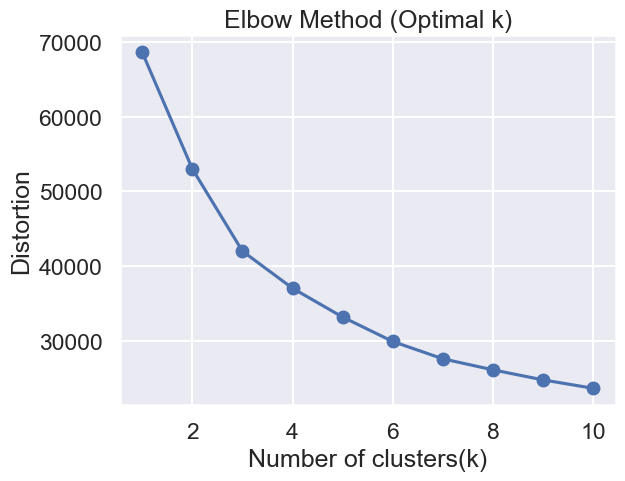

In [40]:
#generating Elbow Method plot to identify optimal k
distortions = []

# set max number of potential clusters to 10
for k in range(1, 11): 
    km = KMeans(n_clusters= k, n_init=10, random_state=0)
    km.fit(x_scaled)
    distortions.append(km.inertia_)
        
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Distortion')
plt.title('Elbow Method (Optimal k)')
plt.show() 

Visible elbow at k=3

In [107]:
#initialize kmeans clustering using optimal # of clusters
k = 3
kmeans = KMeans(n_clusters= k, n_init= 10)
kmeans.fit(x_scaled)

KMeans(n_clusters=3, n_init=10)

In [108]:
#Checking the clusters for each value
kmeans.fit_predict(x_scaled)


array([2, 2, 1, ..., 2, 2, 1])

In [ ]:
# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to DFs
Weather_kmeans['ClusterKM'] = cluster_labels
NYSE_Weather['ClusterKM'] = cluster_labels

# Visualize the clusters using Principal Component Analysis (PCA)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)


In [112]:
#number of results per cluster
Weather_kmeans['ClusterKM'].value_counts()

ClusterKM
0    3731
2    3443
1    2628
Name: count, dtype: int64

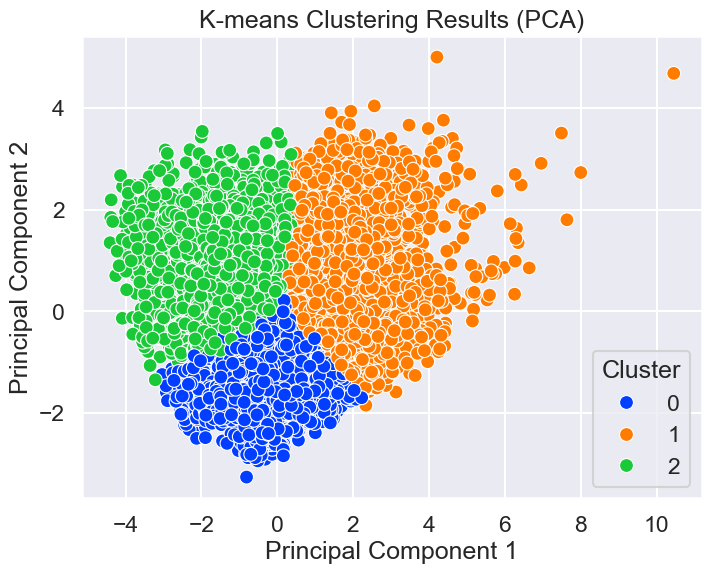

<Figure size 640x480 with 0 Axes>

In [113]:
# Create a scatter plot of the clusters in the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=cluster_labels, palette='bright', s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results (PCA)')
plt.legend(title='Cluster')
plt.show()

plt.savefig('../images/PCA_kmeans.png')

In [110]:
#Means of each cluster, organized by features
#Identifying key characteristics of each cluster
Weather_kmeans.groupby('ClusterKM').mean()

,HOS_Numeric,temp,precip,humidity,windspeed,cloudcover,visibility
ClusterKM,,,,,,,
0,13.885708,21.466845,0.676833,60.669928,20.613535,42.338971,16.466282
1,12.022732,12.693493,9.234744,81.667314,23.860654,88.394216,11.650038
2,10.592216,4.812170,0.381511,53.677781,25.642782,44.356085,19.029712


- Cluster1 :
    - Warmer, sunnier days (more HOS)
- Cluster2 : 
    - Cloudy days, most commonly with precipitation
- Cluster3 : 
    - Cold days with fewer HOS

In [111]:
#seeing how returns vary based on clusters
NYSE_Weather.groupby('ClusterKM')['Returns'].mean()

ClusterKM
0    0.000759
1    0.029822
2    0.074166
Name: Returns, dtype: float64

- The clusters with fewer hours of sunlight showed greater on average returns
    - These cluster presumably coincide with winter/fall
- Clusters with more hours of sunlight showed significantly lower returns
    - These cluster presumably coincide with spring/summer

 - <u>Results align with Previous Findings</u>
    - Warmer days => Likely Spring/Summer => More sun => lower returns
    - Cloudier days => Less sun => higher returns  
    - Cold days => Likely Fall/Winter => Less sun => Even higher returns

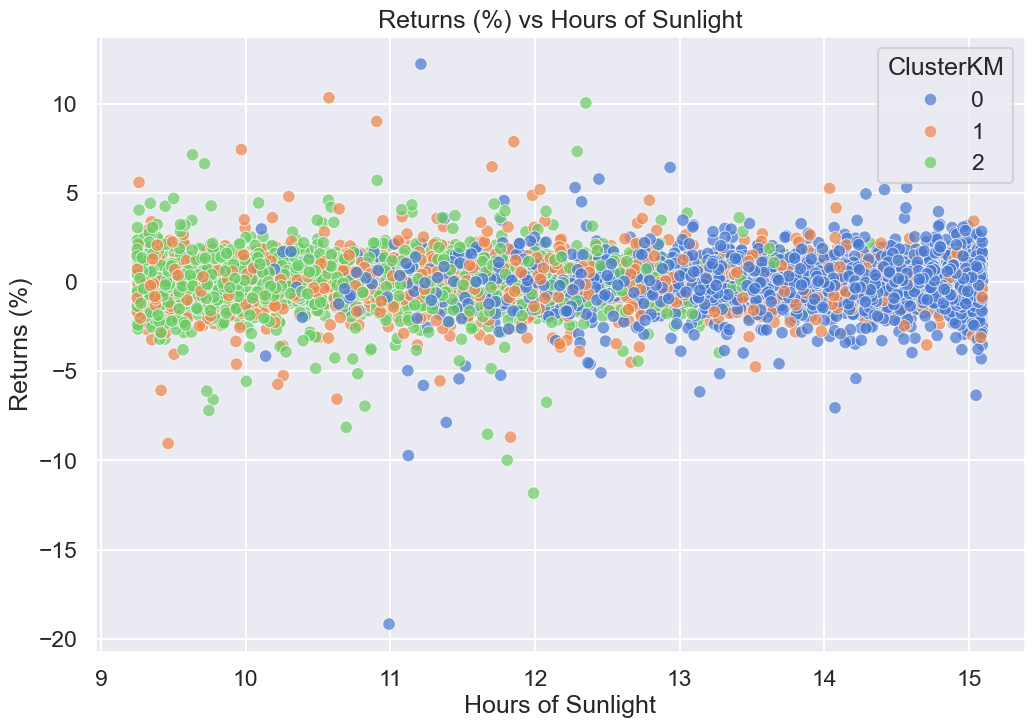

In [121]:
#visualizing distribution of clusters via returns and HOS
plt.figure(figsize=(12,8))
sns.scatterplot(data = NYSE_Weather, x = 'HOS_Numeric', y = 'Returns', hue = 'ClusterKM', palette='muted', alpha=0.7)
plt.xlabel('Hours of Sunlight')
plt.ylabel('Returns (%)')
plt.title('Returns (%) vs Hours of Sunlight')

#saving image
plt.savefig('../images/returns_HOS_ClusterKM.png')

In [22]:
#Perform PCA
pca =PCA()
pca.fit(x_scaled)

#Explained Variance Ratio
EVR = pca.explained_variance_ratio_

#Cumulative Variance Ratio
CVR = EVR.cumsum()

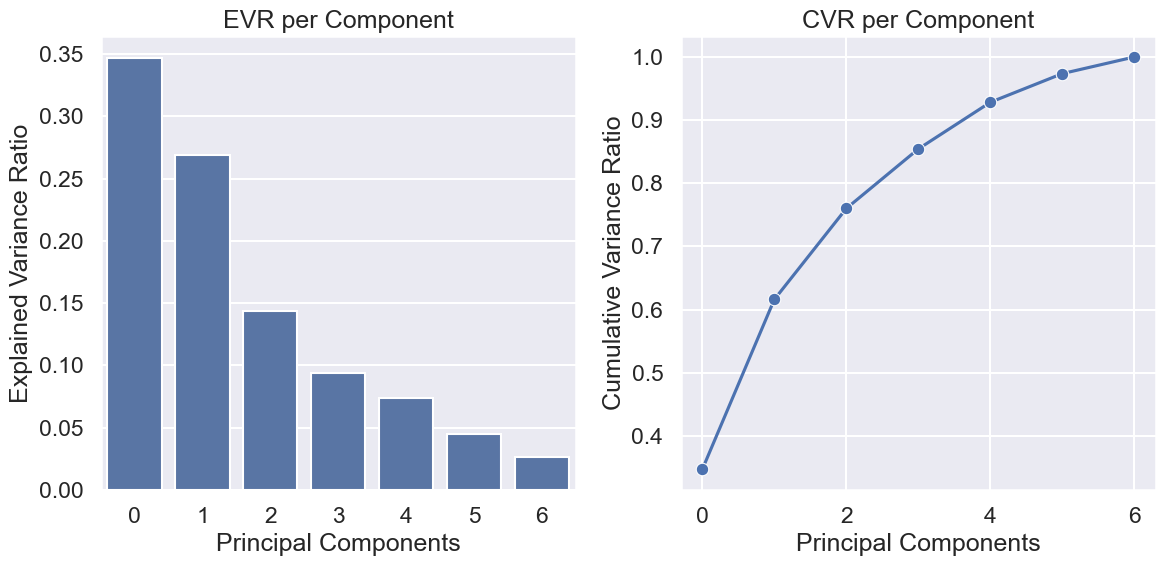

In [23]:
#plot for both explained and cumulative variance ratios
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#Explained Variance Ratio
sns.barplot(EVR, ax=axes[0])
axes[0].set_title('EVR per Component')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance Ratio')

#Cumulative Variance Ratio
sns.lineplot(CVR, ax=axes[1], marker='o')
axes[1].set_title('CVR per Component')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Cumulative Variance Ratio')

#clean layout
plt.tight_layout()

In [126]:
print("Explained variance with 2 PCs :", CVR[1])

Explained variance with 2 PCs : 0.6159720142394991


In [115]:
#saving version of NYSE_Weather DF with clusters included
NYSE_Weather.to_csv('../data/NYSE_Weather_Clusters.csv')

### Classification Model
- Using weather variables to provide buy or sell recommendations
- Essentially turning a linear regression model into a classification model (returns is the proxy for the recommendations)
    

In [26]:
"""Creating dataframe for classification model"""
# create seperate dataframe for one-hot encoded data
one_hot_encoded_data = split_OHE(NYC_no_outliers, 'conditions')

# Concatenate the one-hot encoded data with original NYC_no_outliers df
NYC_no_outliers = pd.concat([NYC_no_outliers, one_hot_encoded_data], axis=1)

#converting dates to datetime
NYC_no_outliers = column_datetime_timedelta(NYC_no_outliers, 'Date', 'Hours_of_Sunlight')

#reducing number of weather columns
monthlyNYSE = NYC_no_outliers[['Date','HOS_Numeric','temp','precip','humidity','windspeed','cloudcover','visibility','Overcast', 'Snow', 'Rain', 'Partially cloudy', 'Clear',
       'Freezing Drizzle/Freezing Rain', 'Ice', 'Returns']]

#aggregating data by month
monthlyNYSE = monthlyNYSE.resample('M', on='Date').mean().reset_index()

#create column for buy/sell recommendation based on return values
monthlyNYSE['Recommendation'] = monthlyNYSE['Returns'].apply(pos_neg_return)

#dropping date and returns columns
monthlyNYSE = monthlyNYSE.drop(columns=['Date', 'Returns'], axis=1)
monthlyNYSE

,HOS_Numeric,temp,precip,humidity,windspeed,cloudcover,visibility,Overcast,Snow,Rain,Partially cloudy,Clear,Freezing Drizzle/Freezing Rain,Ice,Recommendation
0,9.676167,-2.775000,0.512100,62.595000,28.235000,62.340000,21.065000,0.200000,0.350000,0.300000,0.650000,0.150000,0.0,0.0,Buy/Hold
1,10.690205,1.021053,1.677105,61.731579,29.747368,67.263158,18.821053,0.263158,0.263158,0.210526,0.631579,0.105263,0.0,0.0,Buy/Hold
2,11.956323,6.809524,1.233619,49.728571,32.776190,58.242857,24.185714,0.095238,0.047619,0.428571,0.809524,0.095238,0.0,0.0,Sell
3,13.315886,11.661905,1.271429,59.585714,29.247619,57.209524,21.152381,0.142857,0.047619,0.523810,0.666667,0.190476,0.0,0.0,Sell
4,14.458371,17.750000,3.954182,66.990909,27.972727,67.300000,18.804545,0.318182,0.000000,0.409091,0.590909,0.090909,0.0,0.0,Buy/Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,14.738861,26.405000,0.336750,68.025000,18.330000,25.175000,15.300000,0.000000,0.000000,0.750000,0.600000,0.150000,0.0,0.0,Buy/Hold
463,13.751304,23.813043,0.446217,68.039130,20.321739,55.865217,15.591304,0.217391,0.000000,0.608696,0.565217,0.173913,0.0,0.0,Sell
464,12.422889,21.450000,0.803600,70.625000,20.170000,42.490000,14.810000,0.200000,0.000000,0.500000,0.400000,0.350000,0.0,0.0,Sell
465,11.117071,16.904545,0.086091,67.645455,15.681818,31.936364,15.427273,0.136364,0.000000,0.181818,0.318182,0.545455,0.0,0.0,Sell


In [27]:
monthlyNYSE


,HOS_Numeric,temp,precip,humidity,windspeed,cloudcover,visibility,Overcast,Snow,Rain,Partially cloudy,Clear,Freezing Drizzle/Freezing Rain,Ice,Recommendation
0,9.676167,-2.775000,0.512100,62.595000,28.235000,62.340000,21.065000,0.200000,0.350000,0.300000,0.650000,0.150000,0.0,0.0,Buy/Hold
1,10.690205,1.021053,1.677105,61.731579,29.747368,67.263158,18.821053,0.263158,0.263158,0.210526,0.631579,0.105263,0.0,0.0,Buy/Hold
2,11.956323,6.809524,1.233619,49.728571,32.776190,58.242857,24.185714,0.095238,0.047619,0.428571,0.809524,0.095238,0.0,0.0,Sell
3,13.315886,11.661905,1.271429,59.585714,29.247619,57.209524,21.152381,0.142857,0.047619,0.523810,0.666667,0.190476,0.0,0.0,Sell
4,14.458371,17.750000,3.954182,66.990909,27.972727,67.300000,18.804545,0.318182,0.000000,0.409091,0.590909,0.090909,0.0,0.0,Buy/Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,14.738861,26.405000,0.336750,68.025000,18.330000,25.175000,15.300000,0.000000,0.000000,0.750000,0.600000,0.150000,0.0,0.0,Buy/Hold
463,13.751304,23.813043,0.446217,68.039130,20.321739,55.865217,15.591304,0.217391,0.000000,0.608696,0.565217,0.173913,0.0,0.0,Sell
464,12.422889,21.450000,0.803600,70.625000,20.170000,42.490000,14.810000,0.200000,0.000000,0.500000,0.400000,0.350000,0.0,0.0,Sell
465,11.117071,16.904545,0.086091,67.645455,15.681818,31.936364,15.427273,0.136364,0.000000,0.181818,0.318182,0.545455,0.0,0.0,Sell


In [33]:
# Splitting training and test data
x = monthlyNYSE.drop('Recommendation', axis=1)
y = monthlyNYSE['Recommendation']

# Assuming 'buy' is encoded as 1
y = (y == 'Buy/Hold').astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#creating a random forest model
RF_model = RandomForestClassifier()
RF_model.fit(x_train, y_train)

# Prediction values for testing data
RF_predict = RF_model.predict(x_test)


In [124]:
#Display metrics for random forest model
pos_label = 1
RF_metrics = eval_metrics(RF_model, RF_predict, y_test, x_test, pos_label)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, metrics in enumerate(metrics_names):
    print(f'{metrics_names[i]}: {RF_metrics[i]:.2f}') 

Accuracy: 0.73
Precision: 0.77
Recall: 0.91
F1-Score: 0.83
ROC-AUC: 0.63


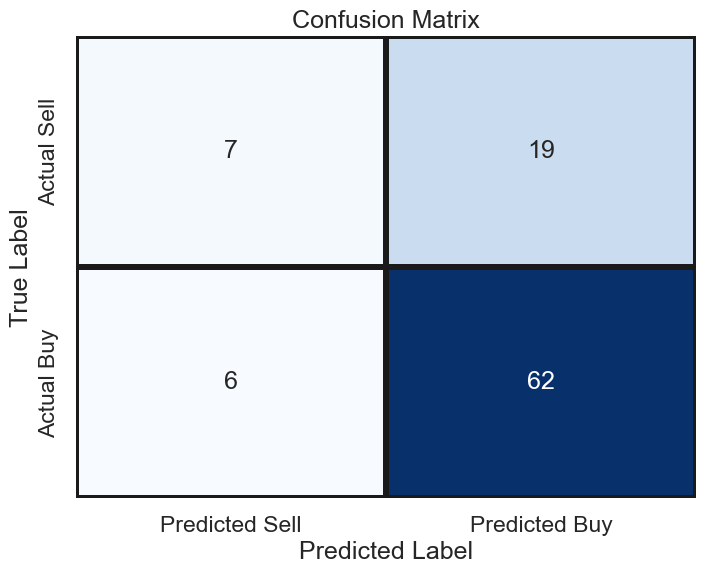

In [133]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, RF_predict)

# Generate heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'Blues',linewidths=3, linecolor="k", cbar=False,
            xticklabels=['Predicted Sell', 'Predicted Buy'],
            yticklabels=['Actual Sell', 'Actual Buy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('../images/confusion_matrix.png')

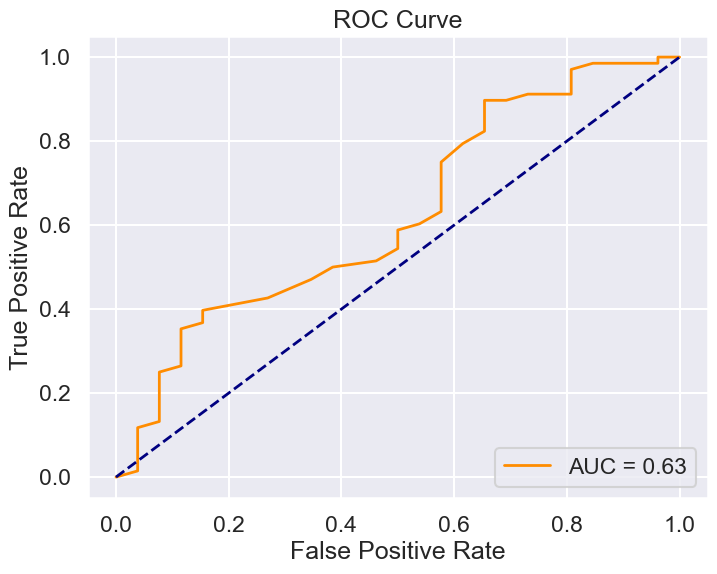

In [37]:
"""ROC Curve"""
# Probabilites for positive class (buy)
y_scores = RF_model.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

#save image
plt.savefig('../images/ROC_AUC.png')


<u> Notes </u>
- Evaluation metrics increased, on average, using data without outliers
- The addition of one-hot encoded data provided no improvements to metrics
- Scaling x variables showed no significant changes in performance